# Reconocedor de lengua de signos

Vamos a desarrollar una red que reconozca lengua de signos. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes, debemos montar nuestro sistema de archivos de Google Drive para hacerlo accesible desde este *notebook*. Google nos solicitará permiso, tenemos que copiar y pegar el código que nos suministra.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ahora ya es accesible

¿Estoy realmente utilizando una GPU? Compruébalo en **Editar / Configuración del cuaderno** o **Entorno de ejecución / Cambiar tipo de entorno de ejecución**

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Veamos una imagen de ejemplo.

'ace of clubs'	     'four of hearts'	 'nine of spades'     'ten of diamonds'
'ace of diamonds'    'four of spades'	 'queen of clubs'     'ten of hearts'
'ace of hearts'      'jack of clubs'	 'queen of diamonds'  'ten of spades'
'ace of spades'      'jack of diamonds'  'queen of hearts'    'three of clubs'
'eight of clubs'     'jack of hearts'	 'queen of spades'    'three of diamonds'
'eight of diamonds'  'jack of spades'	 'seven of clubs'     'three of hearts'
'eight of hearts'     joker		 'seven of diamonds'  'three of spades'
'eight of spades'    'king of clubs'	 'seven of hearts'    'two of clubs'
'five of clubs'      'king of diamonds'  'seven of spades'    'two of diamonds'
'five of diamonds'   'king of hearts'	 'six of clubs'       'two of hearts'
'five of hearts'     'king of spades'	 'six of diamonds'    'two of spades'
'five of spades'     'nine of clubs'	 'six of hearts'
'four of clubs'      'nine of diamonds'  'six of spades'
'four of diamonds'   'nine of hearts'	 'ten of cl

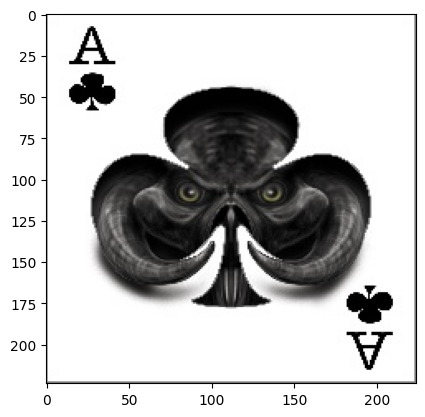

In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/archive/test"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/archive/test/ace of clubs/1.jpg', 'r')
imshow(np.asarray(pil_im))



## Primer modelo

In [ ]:
# DATA SOURCE --------------------------------------------------

image_size = (250, 250)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/archive/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/archive/valid",
    validation_split=0.99,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 7624 files belonging to 53 classes.
Using 6100 files for training.
Found 265 files belonging to 53 classes.
Using 262 files for validation.


In [ ]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1,
                    input_shape=(250, 250, 3)))
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(53, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [ ]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
191/191 [==============================] - 704s 3s/step - loss: 3.7674 - accuracy: 0.0718 - val_loss: 3.0478 - val_accuracy: 0.2099
Epoch 2/200
191/191 [==============================] - 28s 143ms/step - loss: 3.2425 - accuracy: 0.1707 - val_loss: 2.6557 - val_accuracy: 0.2824
Epoch 3/200
191/191 [==============================] - 28s 140ms/step - loss: 2.9601 - accuracy: 0.2151 - val_loss: 2.3851 - val_accuracy: 0.3473
Epoch 4/200
191/191 [==============================] - 27s 137ms/step - loss: 2.7874 - accuracy: 0.2461 - val_loss: 2.2429 - val_accuracy: 0.3740
Epoch 5/200
191/191 [==============================] - 28s 140ms/step - loss: 2.5627 - accuracy: 0.3046 - val_loss: 1.6635 - val_accuracy: 0.5611
Epoch 6/200
191/191 [==============================] - 28s 140ms/step - loss: 2.1336 - accuracy: 0.4087 - val_loss: 1.4382 - val_accuracy: 0.6145
Epoch 7/200
191/191 [==============================] - 28s 142ms/step - loss: 1.8845 - accuracy: 0.4697 - val_loss: 1.1920 - v

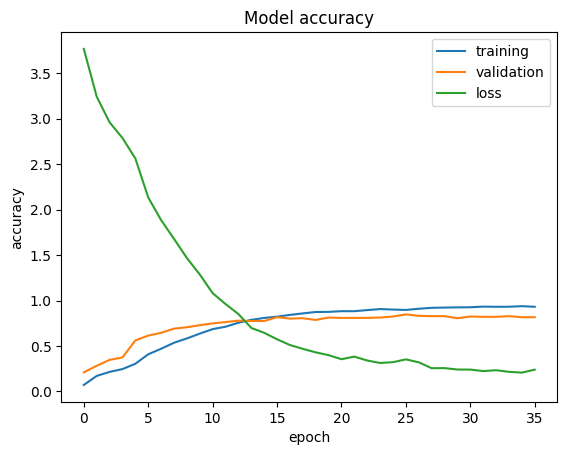

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 124ms/step
              precision    recall  f1-score   support

           0     0.6000    0.6000    0.6000         5
           1     0.8000    0.5714    0.6667         7
           2     1.0000    1.0000    1.0000         5
           3     0.8000    1.0000    0.8889         4
           4     1.0000    0.6250    0.7692         8
           5     1.0000    1.0000    1.0000         5
           6     0.8000    1.0000    0.8889         4
           7     0.8000    1.0000    0.8889         4
           8     1.0000    0.8333    0.9091         6
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     0.6000    0.6000    0.6000         5
          13     1.0000    1.0000    1.0000         5
          14     0.8000    1.0000    0.8889         4
          15     1.0000    0.8333    0.9091         6
          16     0.8000    0

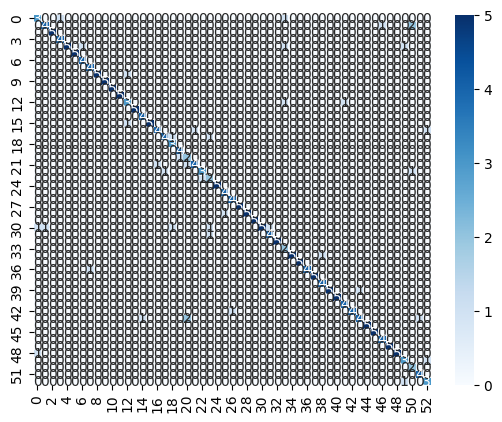

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [ ]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/Sign-Language/2/IMG_4111.JPG', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 318ms/step
20


32
32
32
32
32
32
32
32
6
1/1 [==============================] - 0s 20ms/step
              precision    recall  f1-score   support

           0     0.6000    0.6000    0.6000         5
           1     0.8000    0.5714    0.6667         7
           2     1.0000    1.0000    1.0000         5
           3     0.8000    1.0000    0.8889         4
           4     1.0000    0.6250    0.7692         8
           5     1.0000    1.0000    1.0000         5
           6     0.8000    1.0000    0.8889         4
           7     0.8000    1.0000    0.8889         4
           8     1.0000    0.8333    0.9091         6
           9     1.0000    1.0000    1.0000         5
          10     1.0000    1.0000    1.0000         5
          11     1.0000    1.0000    1.0000         5
          12     0.6000    0.6000    0.6000         5
          13     1.0000    1.0000    1.0000         5
          14     0.8000    1.0000    0.8889         4
          15     1.0000    0.8333    0.9091         6
   

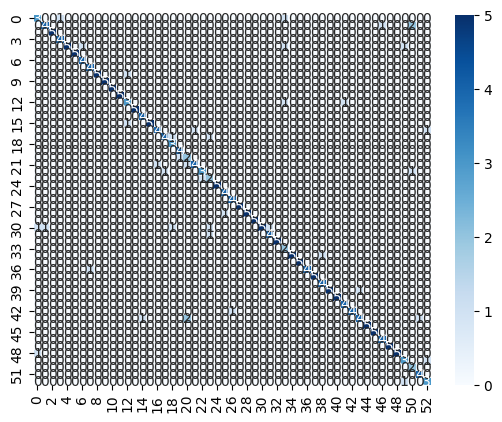

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for x, y in val_ds:
  print(len(y))

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))